# First notebook for experimentation. 
Portions of this notebook has been cleaned and the function's been moved to utils.py for readability. 

In [20]:
import pandas as pd 
import torch 
from torch.utils.data import Dataset
import numpy as np
import torch.nn as nn
import importlib
import utils
import data_processing_utils

importlib.reload(utils)
from utils import *

importlib.reload(data_processing_utils)
from data_processing_utils import *

import models
importlib.reload(models)
from models import *

import pickle
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# You can skip the above steps and directly read in haha_longer.csv 
grouped_df = pd.read_csv('./../data/haha-longer-mid.csv')

In [14]:
# Data exploration: Line by line reading the data -> there are some broken lines
for move,board in (zip(grouped_df['moves'][20:22],grouped_df['board'][20:22])):
    for a,b in zip(move.split(' '),board.split('*')):
        print(a)
        print(b)
    print("new game")

e2e4
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
e7e6
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
g1f3
rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
f7f6
rnbqkbnr/pppp1ppp/4p3/8/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
d2d4
rnbqkbnr/pppp2pp/4pp2/8/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 3
f8d6
rnbqkbnr/pppp2pp/4pp2/8/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3
c2c4
rnbqk1nr/pppp2pp/3bpp2/8/3PP3/5N2/PPP2PPP/RNBQKB1R w KQkq - 1 4
c7c6
rnbqk1nr/pppp2pp/3bpp2/8/2PPP3/5N2/PP3PPP/RNBQKB1R b KQkq - 0 4
h2h3
rnbqk1nr/pp1p2pp/2pbpp2/8/2PPP3/5N2/PP3PPP/RNBQKB1R w KQkq - 0 5
b7b6
rnbqk1nr/pp1p2pp/2pbpp2/8/2PPP3/5N1P/PP3PP1/RNBQKB1R b KQkq - 0 5
b1c3
rnbqk1nr/p2p2pp/1ppbpp2/8/2PPP3/5N1P/PP3PP1/RNBQKB1R w KQkq - 0 6
c8a6
rnbqk1nr/p2p2pp/1ppbpp2/8/2PPP3/2N2N1P/PP3PP1/R1BQKB1R b KQkq - 1 6
b2b3
rn1qk1nr/p2p2pp/bppbpp2/8/2PPP3/2N2N1P/PP3PP1/R1BQKB1R w KQkq - 2 7
c6c5
rn1qk1nr/p2p2pp/bppbpp2/8/2PPP3/1PN2N1P/P4PP1/R1BQKB1R b KQkq - 0 7
d4d5
rn1qk1nr/p2p2pp/bp1bpp2/2p5/2P

Now that we have our raw data, we need to be able to make sense of chess moves. Meaning, we're transforming our entire world from chess moves into numerical tokens that will serve as indices into unique embeddings. 

We'll generate a mapping from each move to a unique embedding. In order to index into our matrix of embeddings (matrix format so it's something we can tune), we'll also want a mapping from each move to a unique ID


In [6]:
with open('./../data/full_vocab.pkl', 'rb') as inp:
    vocab = pickle.load(inp)
    
trainX, trainY, vocab = df_to_sequential_data(grouped_df, vocab, fixed_window=True, sampling_rate=0.5)
trainX, trainX_seqlengths  = pad_sequences(trainX)
print(len(vocab.id_to_move.keys()))
print(len(trainX[140]))

10514
16


In [21]:
"""Note: The input to the Embedding module is a list of indices, and the output is the corresponding word embeddings."""
# Bi-LSTM Model for PyTorch
class RNNModel(nn.Module):
    def __init__(self, vocab, d_embed, d_hidden, d_out, dropout = 0.5, num_layers = 2, bidirectional = False, embedding_matrix = None):
        super(RNNModel, self).__init__()
        self.embeddings = nn.Embedding(len(vocab.move_to_id), d_embed)
        # self.embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(d_embed, d_hidden, dropout = dropout, bidirectional=bidirectional, num_layers = num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_hidden,d_out)
        )

    def forward(self, x, seq_lengths):
        x = self.embeddings(x)
        # Sort x and seq_lengths in descending order
        # This is required for packing the sequence
        seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
        x = x[perm_idx]
        # Pack the sequence
        packed_input = pack_padded_sequence(x, seq_lengths, batch_first=True)
        # Pass the packed sequence through the LSTM
        packed_output, (hidden, cell) = self.lstm(packed_input)

        # Unpack the sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True,total_length = x.size()[1])
        _, unperm_idx = perm_idx.sort(0)
        unperm_idx = unperm_idx.to(device)
        output = output.index_select(0, unperm_idx)
        #This takes all the outputs across the cells
        mean_pooled = torch.mean(output, dim=1)
        #output = torch.cat((mean_pooled,hidden[-1]),dim=1)
        output = self.fc(mean_pooled)
        return output

In [8]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

Functions for training

In [26]:
def train_rnn(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    swa_model = AveragedModel(model)
    swa_start = 1
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for sequences, lengths, labels in train_loader:
            count += 1
            sequences, lengths, labels = sequences.to(device), lengths, labels.to(device)
            # Forward Pass
            output = model(sequences, lengths)
            loss = criterion(output, labels)
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count} | Training Error: {train_correct/train_total}')
        if epoch >= swa_start:
            swa_model.update_parameters(model)
        torch.optim.swa_utils.update_bn(train_loader, swa_model)
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                validation_loss = 0

                for sequences, lengths, labels in val_loader:
                    sequences, lengths, labels = sequences.to(device), lengths, labels.to(device)
                    outputs = model(sequences, lengths)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                val_loss_values.append(validation_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)

        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values, swa_model

Now let's train

In [10]:
dataset = SequenceDataset(trainX, trainX_seqlengths, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)

12262674


## Experiment 1 (with UCI Notation)

In [162]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 128
d_embed = 128
NUM_EPOCHS = 10
d_out = len(vocab.id_to_move.keys())
model = RNNModel(vocab,d_embed,d_hidden,d_out,num_layers=2) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

2155618
1726522


In [ ]:

# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

Achieved up to 9% Accuracy and 15% Top-3 Accuracy

## Experiment 2 (With SAN Notation)

In [9]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2156154


In [10]:
# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 128
d_embed = 64
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
model = RNNModel(vocab,d_embed,d_hidden,d_out,num_layers=2) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
weight_decay=1e-7
learn_decay = 0.7 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1329594


Epoch 1, Batch: 1000| Training Loss: 6.381805346012116
Epoch 1, Batch: 2000| Training Loss: 6.204582467794419
Epoch 1, Batch: 3000| Training Loss: 6.117535646438599
Epoch 1, Batch: 4000| Training Loss: 6.062291540980339
Epoch 1, Batch: 5000| Training Loss: 6.018701215553284
Epoch 1, Batch: 6000| Training Loss: 5.977685891548792
Epoch 1, Batch: 7000| Training Loss: 5.943539698805128
Epoch 1, Batch: 8000| Training Loss: 5.9117176689505575
Epoch 1, Batch: 9000| Training Loss: 5.883537901560466
Epoch 1, Batch: 10000| Training Loss: 5.8553138959884645
Epoch 1, Batch: 11000| Training Loss: 5.830070639696988
Epoch 1, Batch: 12000| Training Loss: 5.807468042810758
Epoch 1, Batch: 13000| Training Loss: 5.783581111834599
Epoch 1, Batch: 14000| Training Loss: 5.761009867157255
Epoch 1, Batch: 15000| Training Loss: 5.737760264619191
Epoch 1, Batch: 16000| Training Loss: 5.716189021110535
Epoch 1, Batch: 17000| Training Loss: 5.693961875382592
Epoch 1, Batch: 18000| Training Loss: 5.674177433278825

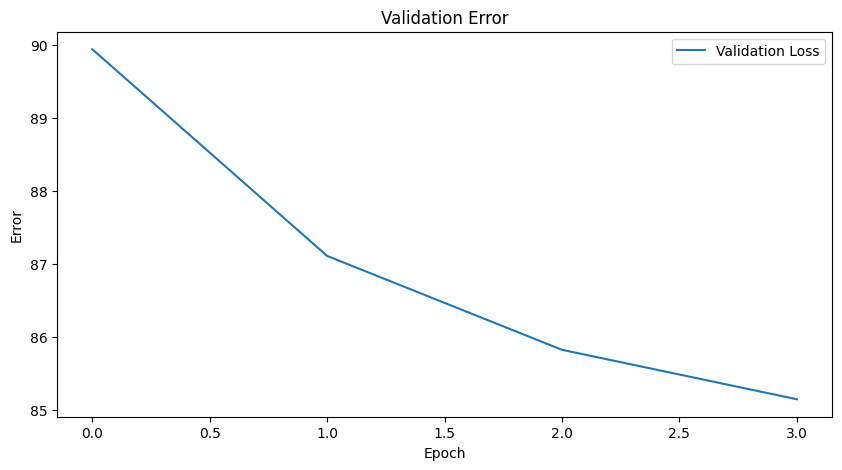

<Figure size 640x480 with 0 Axes>

In [11]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

What happens if we filter out illegal moves in our prediction?

In [ ]:
val_size = int(total_size * 0.04)
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for sequences, lengths, labels in val_loader:
            print("hey")
            sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
            outputs = model(sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    print(predicted_move)
                    chess_board = load_board_state_from_san(sequence)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")


## Experiment 3 (with CLS and SEP)

In [23]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 128
d_embed = 64
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
model = RNNModel(vocab,d_embed,d_hidden,d_out,num_layers=2) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
weight_decay=1e-7
learn_decay = 0.7 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1329787


Epoch 1, Batch: 1000| Training Loss: 6.266912286281586
Epoch 1, Batch: 2000| Training Loss: 6.090791485548019
Epoch 1, Batch: 3000| Training Loss: 6.00199724706014
Epoch 1, Batch: 4000| Training Loss: 5.945224474787712
Epoch 1, Batch: 5000| Training Loss: 5.89297625541687
Epoch 1, Batch: 6000| Training Loss: 5.847457567453384
Epoch 1, Batch: 7000| Training Loss: 5.80684051656723
Epoch 1, Batch: 8000| Training Loss: 5.772834228217602
Epoch 1, Batch: 9000| Training Loss: 5.745762413342794
Epoch 1, Batch: 10000| Training Loss: 5.717693977880478
Epoch 1, Batch: 11000| Training Loss: 5.6909386064789516
Epoch 1, Batch: 12000| Training Loss: 5.667047676841418
Epoch 1, Batch: 13000| Training Loss: 5.643518405804267
Epoch 1, Batch: 14000| Training Loss: 5.619418164253235
Epoch 1, Batch: 15000| Training Loss: 5.595468038272858
Epoch 1, Batch: 16000| Training Loss: 5.573775236010551
Epoch 1, Batch: 17000| Training Loss: 5.5524243117781245
Epoch 1, Batch: 18000| Training Loss: 5.531703988817003
Ep

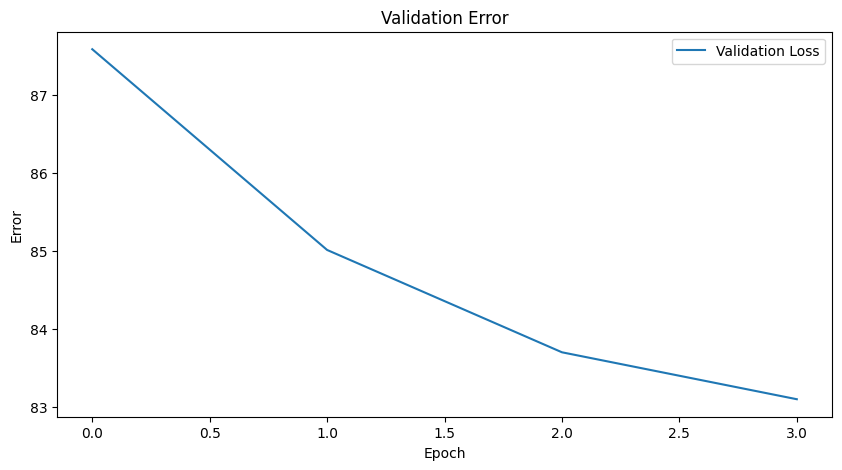

<Figure size 640x480 with 0 Axes>

In [24]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 4 (scale)

In [15]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.97 * total_size)
val_size = int(total_size * 0.02) 
print(train_size)

# has 12261570 data

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 256
d_embed = 256
NUM_EPOCHS = 10
d_out = len(vocab.id_to_move.keys())
model = RNNModel(vocab,d_embed,d_hidden,d_out,num_layers=2) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
weight_decay=1e-7
learn_decay = 0.7 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

5219258


In [16]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('training_results/rnn-4-24.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 6.174941445827484


## Experiment 5 (scale more)

In [24]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.97 * total_size)
val_size = int(total_size * 0.02) 
print(train_size)

# has 12261570 data

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))

# Reload the data with particular batch size
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 512
d_embed = 512
NUM_EPOCHS = 10
d_out = len(vocab.id_to_move.keys())
model = RNNModel(vocab,d_embed,d_hidden,d_out,num_layers=3) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
weight_decay=1e-7
learn_decay = 0.7 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

11894793
17080594


In [27]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('training_results/rnn-exp-5-4-24.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 5.5046594872474675 | Training Error: 0.0573515625
Epoch 1, Batch: 2000| Training Loss: 5.4436685936450955 | Training Error: 0.06194140625
Epoch 1, Batch: 3000| Training Loss: 5.392401083946228 | Training Error: 0.06716666666666667
Epoch 1, Batch: 4000| Training Loss: 5.336905386686325 | Training Error: 0.072328125
Epoch 1, Batch: 5000| Training Loss: 5.2807606303215024 | Training Error: 0.077315625
Epoch 1, Batch: 6000| Training Loss: 5.2277787630558015 | Training Error: 0.082296875
Epoch 1, Batch: 7000| Training Loss: 5.176734137058258 | Training Error: 0.08692633928571429
Epoch 1, Batch: 8000| Training Loss: 5.13035013255477 | Training Error: 0.0911865234375
Epoch 1, Batch: 9000| Training Loss: 5.088371889246835 | Training Error: 0.09502864583333333
Epoch 1, Batch: 10000| Training Loss: 5.047859644246102 | Training Error: 0.0987
Epoch 1, Batch: 11000| Training Loss: 5.01027497326244 | Training Error: 0.1020546875
Epoch 1, Batch: 12000| Training Lo